# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/12gbDwPPkGZ2JLeRMEubQ0KT51OYcuElg/view?usp=sharing 

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

In [229]:
!pip install -U torch==1.8.0 torchtext==0.9.0

# Reload environment
exit()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [2]:
for line in open('SMSSpamCollection'):
    if line.startswith("spam"):
      print("Spam Example:\n",line)
      break
for line in open('SMSSpamCollection'):
    if not line.startswith("spam"):
      print("Non-Spam Example:\n",line)
      break

# For Spam, label is "spam"
# For Non-Spam, label is "ham" 

Spam Example:
 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Non-Spam Example:
 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [3]:
spam = 0
nonspam = 0
total = 0
for line in open('SMSSpamCollection'):
    total += 1
    if line.startswith("spam"):
      spam += 1
    else:
      nonspam += 1
print("Spam:\t ", spam)
print("Non-Spam:", nonspam)
print("Total:\t ", total)

Spam:	  747
Non-Spam: 4827
Total:	  5574


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [ ]:
'''
Advantages
- Allows for the neural network to ignore spelling mistakes within the dataset.
- Thousands of words vs just the alphabet + punctiation characters resulting in
  much smaller embeddings.
Disadvantages
- Slower computation since there's a greater num of characters vs words in a 
  sentence.
- difficulty in capturing the semantic and contextual information that is
  conveyed by complete words possibly resulting in random sentenses 
  without much meaning
'''

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [5]:
import torchtext
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets

text_field = data.Field(tokenize=lambda x: x,batch_first=True)
label_field = data.Field(sequential=False, use_vocab=False, is_target=True, 
                         batch_first=True, preprocessing=lambda x: int(x == 'spam'))
valid_fields = [('label', label_field),('sms', text_field)]
dataset = data.TabularDataset("SMSSpamCollection", "tsv", valid_fields)

train, valid, test = dataset.split(split_ratio=[.6, .2, .2])

print(len(train), len(valid), len(test))

3343 1115 1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
"""
NN will try to get higher accuracy, with a data imbalance, the NN will just
learn to output the label that is more dominant rather than learn features
"""

In [6]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

In [7]:
print(len(train), len(valid), len(test))

6145 1115 1114


### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [8]:
text_field.build_vocab(train)
print(text_field.vocab.stoi) # Dictionary of each token and its index
print(text_field.vocab.itos) # List of tokens at their corresponding index
print(len(text_field.vocab.itos))

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fd45be54c40>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, 'c': 16, 'm': 17, '.': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, 'T': 27, '8': 28, 'k': 29, 'E': 30, '5': 31, 'v': 32, 'S': 33, 'C': 34, 'O': 35, 'I': 36, '4': 37, '7': 38, 'x': 39, 'N': 40, 'A': 41, '3': 42, '6': 43, 'R': 44, '!': 45, ',': 46, 'P': 47, '9': 48, 'W': 49, 'M': 50, 'U': 51, 'L': 52, 'H': 53, 'D': 54, 'F': 55, 'B': 56, 'G': 57, 'Y': 58, '/': 59, "'": 60, '?': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, 'K': 69, 'j': 70, '*': 71, 'J': 72, ')': 73, ';': 74, '+': 75, '(': 76, 'Q': 77, 'q': 78, '"': 79, '#': 80, '>': 81, '=': 82, '@': 83, 'ü': 84, 'Z': 85, '$': 86, 'Ü': 87, '<': 88, '‘': 89, '_': 90, '%': 91, '\x92': 92, '[': 93, ']': 94, '|': 95, '’': 96, '\x93': 97, 'ú': 98,

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [ ]:
# <unk> - Unknown token
# <pad> - Padding token

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [9]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

val_iter = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [10]:
i = 1
for batch in train_iter:
    max = 0
    pad = 0
    for sms in batch.sms:
      if len(sms)>max:
        max = len(sms)
      for char in sms:
        if char == torch.tensor([text_field.vocab.stoi['<pad>']]):
          pad += 1
    print("Batch:",i)
    print("Max sequence length:", max)
    print("Padding:", pad)
    print("")

    if i == 10:
      break
    i+=1

Batch: 1
Max sequence length: 156
Padding: 6

Batch: 2
Max sequence length: 135
Padding: 2

Batch: 3
Max sequence length: 152
Padding: 0

Batch: 4
Max sequence length: 159
Padding: 0

Batch: 5
Max sequence length: 15
Padding: 184

Batch: 6
Max sequence length: 98
Padding: 103

Batch: 7
Max sequence length: 156
Padding: 0

Batch: 8
Max sequence length: 136
Padding: 2

Batch: 9
Max sequence length: 151
Padding: 12

Batch: 10
Max sequence length: 118
Padding: 104



## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [11]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [4]:
class Detect_Spam(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Detect_Spam, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.ident = torch.eye(input_size)
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size) 
        x, _ = self.rnn(self.ident[x], h0)
        x = torch.cat([torch.max(x, dim=1)[0], torch.mean(x, dim=1)], dim=1)
        x = self.fc(x)
        return x

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [13]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    # Data is single sentence dataset (not dataloader or batched data)
    correct = 0
    total = 0
    for sms, label in data:
      output = model(sms)
      prediction = output.max(1, keepdim=True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()
      # Number of messages in batch
      total += label.shape[0]
    accuracy = float(correct / total)
    return accuracy

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [14]:
def train(model, train_loader, valid_loader, batch_size, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_accuracy = np.zeros(num_epochs)
    val_accuracy = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        total_loss = 0
        count = 0
        for message, labels in train_loader:
            optimizer.zero_grad()
            pred = model(message)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss
            count += 1
        
        train_loss[epoch] = float(total_loss/count)

        total_loss = 0
        count = 0
        for message, labels in valid_loader:
            pred = model(message)
            loss = criterion(pred, labels)
            total_loss += loss
            count += 1
        
        val_loss[epoch] = float(total_loss/count)

        train_accuracy[epoch] = get_accuracy(model, train_loader)
        val_accuracy[epoch] = get_accuracy(model, valid_loader)
        print("Epoch %d; Training Loss %f; Val Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, train_loss[epoch], val_loss[epoch], train_accuracy[epoch], val_accuracy[epoch]))
    
    import matplotlib.pyplot as plt

    plt.plot(np.arange(1, num_epochs + 1), train_accuracy, label="train")
    plt.plot(np.arange(1, num_epochs + 1), val_accuracy, label="val")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.plot(np.arange(1, num_epochs + 1), train_loss, label="train")
    plt.plot(np.arange(1, num_epochs + 1), val_loss, label="val")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Epoch 1; Training Loss 0.699661; Val Loss 0.653822; Train Acc 0.473068; Val Acc 0.869058
Epoch 2; Training Loss 0.697093; Val Loss 0.657894; Train Acc 0.479902; Val Acc 0.868161
Epoch 3; Training Loss 0.694348; Val Loss 0.661908; Train Acc 0.485761; Val Acc 0.861883
Epoch 4; Training Loss 0.692419; Val Loss 0.665907; Train Acc 0.503987; Val Acc 0.855605
Epoch 5; Training Loss 0.689903; Val Loss 0.667831; Train Acc 0.531977; Val Acc 0.849327
Epoch 6; Training Loss 0.687508; Val Loss 0.671692; Train Acc 0.585028; Val Acc 0.841256
Epoch 7; Training Loss 0.685249; Val Loss 0.674391; Train Acc 0.630757; Val Acc 0.839462
Epoch 8; Training Loss 0.682962; Val Loss 0.676456; Train Acc 0.693897; Val Acc 0.815247
Epoch 9; Training Loss 0.680070; Val Loss 0.678627; Train Acc 0.714402; Val Acc 0.775785
Epoch 10; Training Loss 0.677704; Val Loss 0.680122; Train Acc 0.712775; Val Acc 0.764126
Epoch 11; Training Loss 0.674767; Val Loss 0.679812; Train Acc 0.732954; Val Acc 0.753363
Epoch 12; Training 

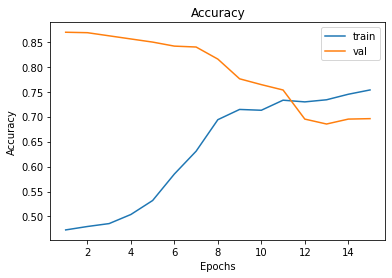

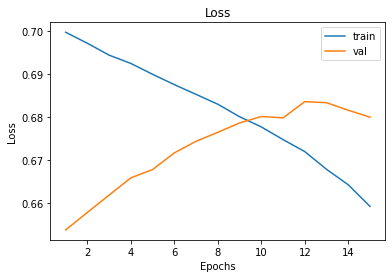

In [17]:
TestRNN = Detect_Spam(len(text_field.vocab.itos), int(len(text_field.vocab.itos)/2))
train(TestRNN, train_iter, val_iter, 32,15)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1; Training Loss 0.694773; Val Loss 0.666478; Train Acc 0.621806; Val Acc 0.800000
Epoch 2; Training Loss 0.665522; Val Loss 0.660865; Train Acc 0.751343; Val Acc 0.705830
Epoch 3; Training Loss 0.443385; Val Loss 0.418675; Train Acc 0.893247; Val Acc 0.865471
Epoch 4; Training Loss 0.294012; Val Loss 0.263550; Train Acc 0.915541; Val Acc 0.922870
Epoch 5; Training Loss 0.253316; Val Loss 0.271456; Train Acc 0.934418; Val Acc 0.920179
Epoch 6; Training Loss 0.237286; Val Loss 0.282705; Train Acc 0.933605; Val Acc 0.932735
Epoch 7; Training Loss 0.210542; Val Loss 0.195714; Train Acc 0.943694; Val Acc 0.953363
Epoch 8; Training Loss 0.214365; Val Loss 0.175535; Train Acc 0.939788; Val Acc 0.956951
Epoch 9; Training Loss 0.187563; Val Loss 0.266103; Train Acc 0.934255; Val Acc 0.913901
Epoch 10; Training Loss 0.183089; Val Loss 0.184204; Train Acc 0.945972; Val Acc 0.949776
Epoch 11; Training Loss 0.181246; Val Loss 0.177679; Train Acc 0.948413; Val Acc 0.955157
Epoch 12; Training 

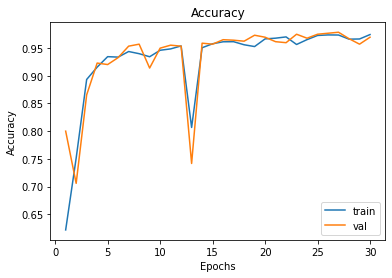

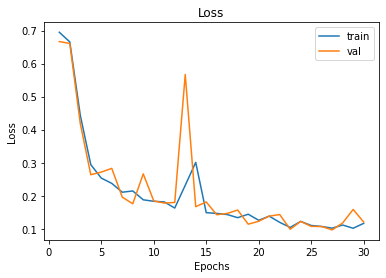

In [19]:
# Increased Num of Epoch and increased learning rate due to slow increase in accuracy

TestRNN = Detect_Spam(len(text_field.vocab.itos), int(len(text_field.vocab.itos)))
train(TestRNN, train_iter, val_iter, 32, 30, 5e-5)

Epoch 1; Training Loss 0.691049; Val Loss 0.717379; Train Acc 0.561432; Val Acc 0.162332
Epoch 2; Training Loss 0.681464; Val Loss 0.709049; Train Acc 0.592677; Val Acc 0.297758
Epoch 3; Training Loss 0.658703; Val Loss 0.698193; Train Acc 0.623434; Val Acc 0.369507
Epoch 4; Training Loss 0.433442; Val Loss 0.354431; Train Acc 0.912286; Val Acc 0.931839
Epoch 5; Training Loss 0.301210; Val Loss 0.226573; Train Acc 0.885598; Val Acc 0.949776
Epoch 6; Training Loss 0.251061; Val Loss 0.257147; Train Acc 0.934093; Val Acc 0.939013
Epoch 7; Training Loss 0.225402; Val Loss 0.244900; Train Acc 0.934744; Val Acc 0.955157
Epoch 8; Training Loss 0.204242; Val Loss 0.205845; Train Acc 0.938812; Val Acc 0.948879
Epoch 9; Training Loss 0.203578; Val Loss 0.234057; Train Acc 0.951668; Val Acc 0.935426
Epoch 10; Training Loss 0.177130; Val Loss 0.205637; Train Acc 0.953946; Val Acc 0.949776
Epoch 11; Training Loss 0.192359; Val Loss 0.210749; Train Acc 0.945484; Val Acc 0.952466
Epoch 12; Training 

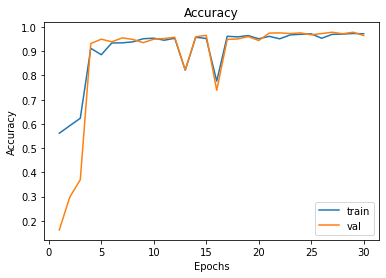

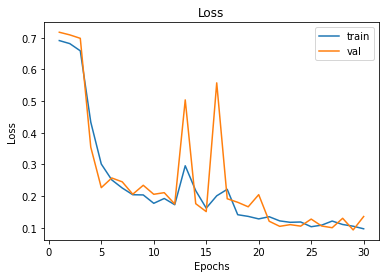

In [20]:
# Decreased Learning rate due to shaking accuracy in later epoch
###
# OTHER HYPERPARAMETERS:
# Changed number of hidden layers to help detect more features (see *1.3 below)
# Tested using max-pool over the entire output array in my RNN

TestRNN = Detect_Spam(len(text_field.vocab.itos), int(len(text_field.vocab.itos)*1.3))
train(TestRNN, train_iter, val_iter, 32, 30, 3e-5)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [26]:
# Create a Dataset of only spam validation examples
valid_spam = data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)
'''
false positive = where looks like spam on not spam
false negative = looks like not spam on spam
'''
valid_spam = data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
valid_nospam = data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
print('False Positive Rate =',(1 - get_accuracy(TestRNN, valid_nospam)))
print('False Negative Rate =',(1 - get_accuracy(TestRNN, valid_spam)))

False Positive Rate = 0.024767801857585092
False Negative Rate = 0.07534246575342463


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [ ]:
'''
False positive
Will be removing real messages from your phone.
This can include important messeges such as those from the government 
or other important institutions (hospitals, university). 
This may start to affect one's personal life more seriously.

False negatives
Not as detramental to the user. Mostly just a bit more annoying.
Can be detramental if the user does fall victim to the spam. But it can 
easily be defended against if user can personally determine a spam. 
Whereas deletely an important message isn't something easy for a user
to deal with.
'''

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [27]:
test_iter = data.BucketIterator(test,
                                batch_size=32,
                                sort_key=lambda x: len(x.sms), # to minimize padding
                                sort_within_batch=True,        # sort within each batch
                                repeat=False)                  # repeat the iterator for many epochs

print(get_accuracy(TestRNN, test_iter))

0.9497307001795332


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [28]:
# Create a Dataset of only spam validation examples
test_spam = data.Dataset(
    [e for e in valid.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = data.Dataset(
    [e for e in valid.examples if e.label == 0],
    test.fields)
'''
false positive = where looks like spam on not spam
false negative = looks like not spam on spam
'''
test_spam = data.BucketIterator(test_spam,
                                batch_size=32,
                                sort_key=lambda x: len(x.sms), # to minimize padding
                                sort_within_batch=True,        # sort within each batch
                                repeat=False)                  # repeat the iterator for many epochs
test_nospam = data.BucketIterator(test_nospam,
                                  batch_size=32,
                                  sort_key=lambda x: len(x.sms), # to minimize padding
                                  sort_within_batch=True,        # sort within each batch
                                  repeat=False)                  # repeat the iterator for many epochs
print('False Positive Rate =',(1 - get_accuracy(TestRNN, test_nospam)))
print('False Negative Rate =',(1 - get_accuracy(TestRNN, test_spam)))

False Positive Rate = 0.024767801857585092
False Negative Rate = 0.07534246575342463


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [35]:
for message, labels in train_iter:
  print(message)
  break

tensor([[55,  8,  3,  ..., 25, 14, 18],
        [27, 56, 33,  ...,  3,  8, 18],
        [55,  8,  3,  ..., 25, 14, 18],
        ...,
        [49,  9,  7,  ..., 45,  1,  1],
        [27, 13,  6,  ..., 25,  1,  1],
        [35, 29, 18,  ..., 20,  1,  1]])


In [62]:
msg = "machine learning is sooo cool!"
msg_char = []
for char in msg:
  msg_char.append(text_field.vocab.stoi[char])
print(msg_char)
pred = TestRNN(torch.from_numpy(np.transpose(torch.LongTensor(msg_char).unsqueeze(1).numpy())))
print(torch.argmax(pred, 1))

# RNN Detected the message as 0 = not spam

[17, 6, 16, 13, 9, 7, 3, 2, 11, 3, 6, 8, 7, 9, 7, 22, 2, 9, 10, 2, 10, 4, 4, 4, 2, 16, 4, 4, 11, 45]
tensor([0])


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
'''
To build a simple baseline model for spam detection. There are a few approaches that
can be taken. Spam messages/emails typically contain similar key words.
Especially spam of similar types. The first algorithm that can be used
is one that detects these key words.
This can include words such as "won" or "congradulations" 
or "account" (has been) "locked".

Another approach is to take in messages reported as spam by users and find out
new keywords that new spams are using. We'll ignore common words and see 
what new words and sequences of words that new spams are using.

We can also maybe look into the puctuation and grammer. If the sender is
unknown is has broken grammer or english in their message/email, there is a 
high likelyhood of it being a spam. 

If it's from a known sender (e.g. friend),
we can use a small NN or some algorithm to look at previous messages sent
by the sender and see if the format of the new message sent is similar to
those of previous messages sent. If not, there is a chance of someone 
hacking their account and sending you spam.

These are just a few baseline models that could be implemented and used to
compare against our NN. The main issue is that many of these need to be 
implemented manually.
'''